<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/p5_notebook_1_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OLIST DATABASE

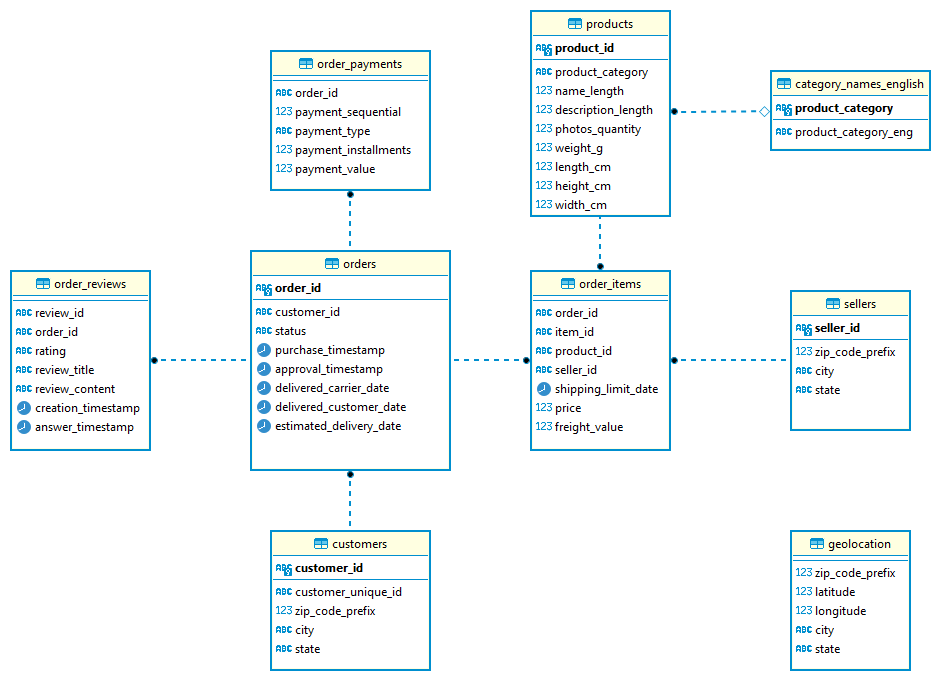

In [1]:
import time
import pandas as pd
import numpy as np
from sqlite3 import connect
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly.express as px

In [2]:
init_time = time.time()

## | Requêtes SQL pour le Dashboard

* En excluant les commandes annulées, quelles sont les commandes
récentes de moins de 3 mois que les clients ont reçues avec au moins 3
jours de retard ?

* Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100
000 Real sur des commandes livrées via Olist ?

* Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui
sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30
produits) ?

* Question : Quels sont les 5 codes postaux, enregistrant plus de 30
reviews, avec le pire review score moyen sur les 12 derniers mois ?

In [3]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

In [4]:
db_path = f"{folder_path}olist.db"
conn = connect(db_path)
cur = conn.cursor()

## | Les tables de la base de données olist

In [5]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)
print(tables)

            name
0      customers
1         geoloc
2    order_items
3    order_pymts
4  order_reviews
5         orders
6       products
7        sellers
8    translation


## | Récupération des données

In [6]:
def extract_transform_and_load_olist_data():

  # Extract orders
  print("Extraction des commandes ...")
  orders = pd.read_sql(
    """
    SELECT
      order_id,
      order_purchase_timestamp,
      order_approved_at,
      order_delivered_carrier_date,
      order_delivered_customer_date,
      order_estimated_delivery_date,
      strftime('%w', order_delivered_customer_date) AS delivery_day
    FROM orders o
    WHERE o.order_status='delivered'
    """,
    conn
  )

  # Extract order items
  print("Extraction des articles ...")
  items = pd.read_sql(
    """
    SELECT
      oi.order_id,
      COUNT(order_item_id) as nbre_items,
      SUM(price+freight_value) as total_price,
      COUNT(DISTINCT oi.product_id) AS distinct_products
    FROM order_items oi
    JOIN orders o on oi.order_id=o.order_id
    WHERE o.order_status='delivered'
    GROUP BY oi.order_id
    """,
    conn
  )

  # Extract customers
  print("Extraction des clients ...")
  customers = pd.read_sql(
    """
    SELECT
      o.order_id,
      customer_unique_id,
      customer_zip_code_prefix,
      customer_city,
      customer_state
    FROM customers c
    JOIN orders o on o.customer_id = c.customer_id
    WHERE o.order_status='delivered'
    """,
    conn
  )

  # Extract reviews
  print("Extraction des commentaires ...")
  reviews = pd.read_sql(
    """
    SELECT
      o.order_id,
      COUNT(r.review_id) as total_reviews,
      COALESCE(AVG(r.review_score), 0) AS mean_score_review
    FROM orders o
    LEFT JOIN order_reviews r on o.order_id=r.order_id
    WHERE o.order_status='delivered'
    GROUP BY o.order_id
    """,
    conn
  )

  # Extract payments
  print("Extraction des paiments ...")
  payments = pd.read_sql(
    """
    SELECT
      p.order_id,
      MAX(payment_installments) as payment_installments
    FROM order_pymts p
    JOIN orders o on o.order_id=p.order_id
    WHERE o.order_status='delivered'
    GROUP BY p.order_id
    """,
    conn
  )
  print("--"*20)

  # Tranform

  print("Merger des items ...")
  data = orders.merge(items, on='order_id')

  print("Merger des clients ...")
  data = data.merge(customers, on='order_id')

  print("Merger des paiments ...")
  data = data.merge(reviews, on='order_id')

  print("Merger des paiments ...")
  data = data.merge(payments, on='order_id')

  print("--"*20)
  print(f"Dimension du dataset: {data.shape}")

  return data

In [7]:
data = extract_transform_and_load_olist_data()

Extraction des commandes ...
Extraction des articles ...
Extraction des clients ...
Extraction des commentaires ...
Extraction des paiments ...
----------------------------------------
Merger des items ...
Merger des clients ...
Merger des paiments ...
Merger des paiments ...
----------------------------------------
Dimension du dataset: (96477, 17)


In [8]:
data.dtypes

,0
order_id,object
order_purchase_timestamp,object
order_approved_at,object
order_delivered_carrier_date,object
order_delivered_customer_date,object
order_estimated_delivery_date,object
delivery_day,object
nbre_items,int64
total_price,float64
distinct_products,int64


In [9]:
# Conversion explicite des colonnes en datetime si ce n'est pas fait correctement
date_columns = [
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_customer_date", "order_delivered_carrier_date",
    "order_estimated_delivery_date"
]

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

In [10]:
data.dtypes

,0
order_id,object
order_purchase_timestamp,datetime64[ns]
order_approved_at,datetime64[ns]
order_delivered_carrier_date,datetime64[ns]
order_delivered_customer_date,datetime64[ns]
order_estimated_delivery_date,datetime64[ns]
delivery_day,object
nbre_items,int64
total_price,float64
distinct_products,int64


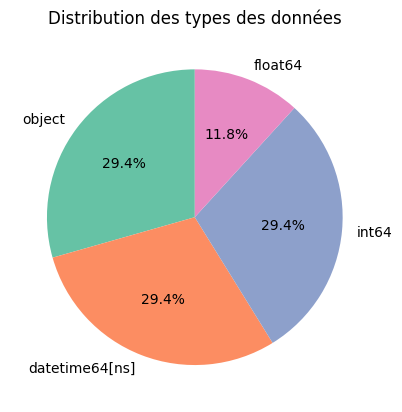

In [11]:
dtype_counts = data.dtypes.value_counts()

dtype_counts.plot.pie(autopct="%1.1f%%", labels=dtype_counts.index,startangle=90, colors=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"])
plt.title("Distribution des types des données")
plt.ylabel("")  # Remove default ylabel
plt.show()

In [12]:
data.isna().sum().sort_values(ascending=False)

,0
order_approved_at,14
delivery_day,8
order_delivered_customer_date,8
order_delivered_carrier_date,2
order_id,0
order_purchase_timestamp,0
order_estimated_delivery_date,0
nbre_items,0
total_price,0
distinct_products,0


Nous constatons la presence de valeurs manquantes dans les variables:
- **order_approved_at**
- **order_delivered_customer_date**
- **order_delivered_carrier_date**

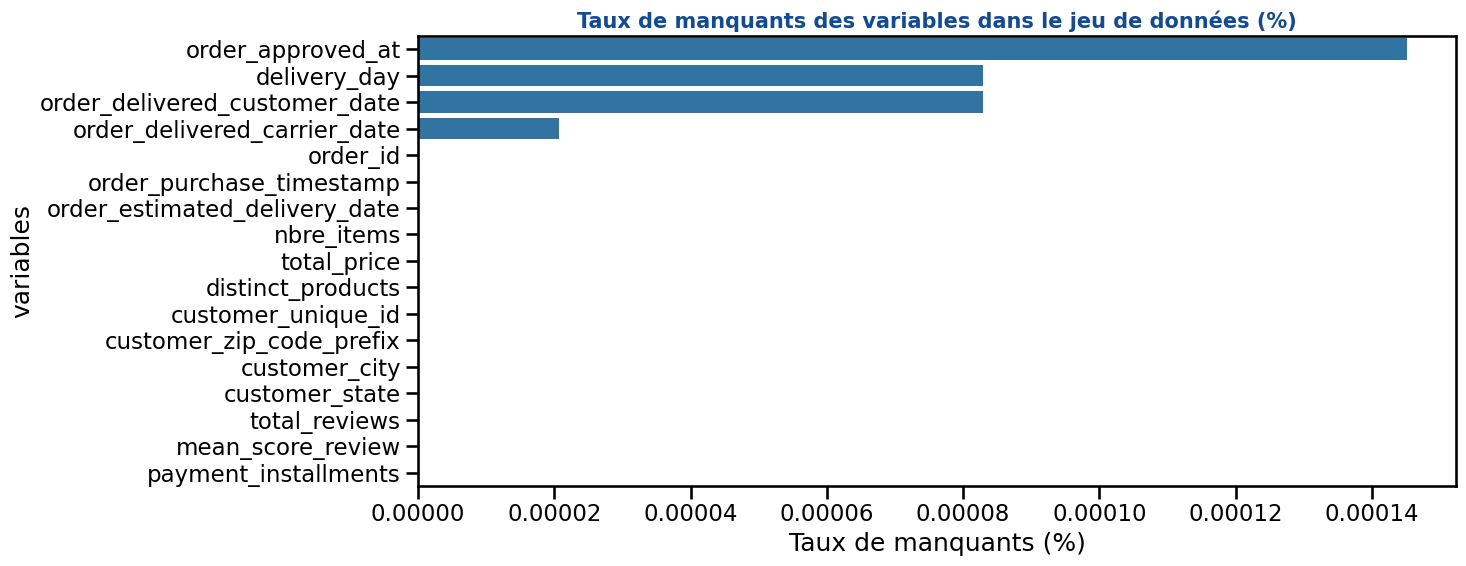

In [13]:
sns.set_context("talk")

vars = pd.DataFrame(data.isnull().mean(), columns=['Taux_de_Null']).sort_values(
    by='Taux_de_Null', ascending=False)
fig = plt.figure(figsize=(15, 6))

font_title = {'color':  '#114b98','weight': 'bold','size': 15}

sns.barplot(x=vars.Taux_de_Null, y=vars.index, data=vars)

# Seuil pour suppression des variables
# plt.axvline(x=max_threshold, linewidth=2, color = 'r')
# plt.text(max_threshold+0.1, 20, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de manquants des variables dans le jeu de données (%)",
          fontdict=font_title)
plt.xlabel("Taux de manquants (%)")
plt.ylabel("variables")

fig.tight_layout()

plt.show()

In [14]:
data.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,nbre_items,total_price,distinct_products,customer_zip_code_prefix,total_reviews,mean_score_review,payment_installments
count,96477,96463,96475,96469,96477,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000,96477.000000
mean,2018-01-01 23:36:35.953657344,2018-01-02 11:00:27.838653440,2018-01-05 05:08:10.179476480,2018-01-14 12:47:59.778654464,2018-01-25 17:17:01.039211264,1.142179,159.827008,1.038538,35198.398862,0.998787,4.128390,2.928024
min,2016-10-03 09:44:50,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-27 00:00:00,1.000000,9.590000,1.000000,1003.000000,0.000000,0.000000,0.000000
25%,2017-09-14 09:09:57,2017-09-14 14:50:09.500000,2017-09-18 16:47:13,2017-09-25 22:18:08,2017-10-05 00:00:00,1.000000,61.850000,1.000000,11355.000000,1.000000,4.000000,1.000000
50%,2018-01-20 19:46:23,2018-01-22 13:50:04,2018-01-24 16:14:57,2018-02-02 19:36:08,2018-02-16 00:00:00,1.000000,105.280000,1.000000,24435.000000,1.000000,5.000000,2.000000
75%,2018-05-05 18:56:01,2018-05-06 11:01:45.500000,2018-05-08 14:35:00,2018-05-15 22:56:45,2018-05-28 00:00:00,1.000000,176.260000,1.000000,59056.000000,1.000000,5.000000,4.000000
max,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,21.000000,13664.080000,8.000000,99980.000000,3.000000,5.000000,24.000000
std,NaN,NaN,NaN,NaN,NaN,0.538773,218.795346,0.227943,29839.786348,0.110728,1.323427,2.712723


In [15]:
data.describe(include='O')

,order_id,delivery_day,customer_unique_id,customer_city,customer_state
count,96477,96469,96477,96477,96477
unique,96477,7,93357,4085,27
top,66dea50a8b16d9b4dee7af250b4be1a5,1,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,18892,15,15045,40500


In [16]:
data.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_day,nbre_items,total_price,distinct_products,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,total_reviews,mean_score_review,payment_installments
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2,1,38.71,1,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,4.0,1
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2,1,141.46,1,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,4.0,1
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,5,1,179.12,1,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,5.0,3
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,6,1,72.20,1,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,5.0,1
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,5,1,28.62,1,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,5.0,1


## | Gestion des Valeurs manquantes

Nous avons remarqué plus haut que les trois varibales **order_approved_at**, **order_delivered_customer_date**, **order_delivered_carrier_date** presentent des valeurs manquantes qui devront etre imputer ou supprimer avant de poursuivre l'ananlyse.

L'approche que nous allons choisir consiste:

- Pour la variable **order_approved_at**: nous allons calculer le temps moyen entre order_purchase_timestamp (le moment où l'achat a été effectué) et order_approved_at (le moment où l'achat a été validé) puis ensuite nous allons imputer les valeur manquantes en addition order_purchase_timestamp avec la moyenne trouvée.

- Pour la variable **order_delivered_customer_date**: Nous allons calculer la moyenne entre cette variable et la date estimée de la livraison (**order_estimated_delivery_date**)

- Pour la variable **order_delivered_carrier_date**, on imputera les valeurs manquantes par la moyenne entre la date de validation et la variable.

In [17]:
missing_cols = data.columns[data.isnull().any()].tolist()
print(missing_cols)

['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'delivery_day']


### | order_approved_at

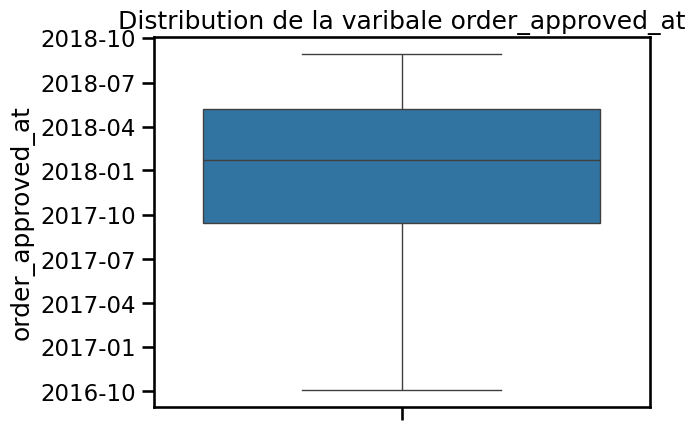

In [18]:
sns.boxplot(data.order_approved_at)
plt.title("Distribution de la varibale order_approved_at")
plt.show()

In [19]:
data["approval_delay"] = (data["order_approved_at"] - data["order_purchase_timestamp"]).dt.total_seconds() / 3600
mean_approval_delay = data["approval_delay"].mean()

In [20]:
print(f"En moyenne les commandes sont validée en {mean_approval_delay:.0f} heures")

En moyenne les commandes sont validée en 10 heures


In [21]:
# Imputation des valeurs manquantes pour order_approved_at
data.loc[data["order_approved_at"].isna(), "order_approved_at"] = data["order_purchase_timestamp"] + pd.to_timedelta(mean_approval_delay, unit="h")

In [22]:
data.order_approved_at.isna().sum()

np.int64(0)

### | order_delivered_customer_date

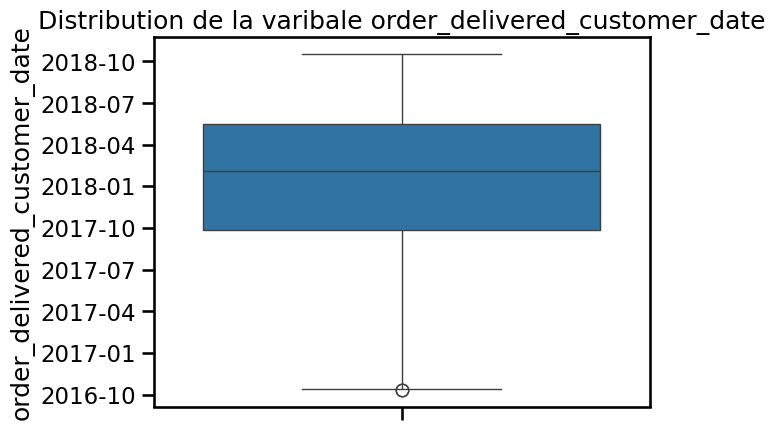

In [23]:
sns.boxplot(data.order_delivered_customer_date)
plt.title("Distribution de la varibale order_delivered_customer_date")
plt.show()

In [24]:
# Calcul du délai moyen entre order_delivered_customer_date et order_estimated_delivery_date
data["delivery_delay"] = (data["order_delivered_customer_date"] - data["order_estimated_delivery_date"]).dt.total_seconds() / (3600*24)
mean_delivery_delay = data["delivery_delay"].mean()
if mean_delivery_delay > 0:
  print(f"En moyenne les commandes sont livrée {-mean_delivery_delay:.0f} jours en retard")
else:
  print(f"En moyenne les commandes sont livrée {-mean_delivery_delay:.0f} jour en avance")

En moyenne les commandes sont livrée 11 jour en avance


In [25]:
# Imputation des valeurs manquantes pour order_delivered_customer_date
data.loc[data["order_delivered_customer_date"].isna(), "order_delivered_customer_date"] = data["order_estimated_delivery_date"] + pd.to_timedelta(mean_delivery_delay, unit="d")

In [26]:
data.order_delivered_customer_date.isna().sum()

np.int64(0)

### | order_delivered_carrier_date

In [27]:
# Calcul du délai moyen entre order_approved_at et order_delivered_carrier_date
data["carrier_delay"] = (data["order_delivered_carrier_date"] - data["order_approved_at"]).dt.total_seconds() / (3600*24)
mean_carrier_delay = data["carrier_delay"].mean()

print(f"En moyenne les commandes sont prises en charges par le transporteur sous {mean_carrier_delay:.0f} jours")

En moyenne les commandes sont prises en charges par le transporteur sous 3 jours


In [28]:
# Imputation des valeurs manquantes pour order_delivered_carrier_date
data.loc[data["order_delivered_carrier_date"].isna(), "order_delivered_carrier_date"] = data["order_approved_at"] + pd.to_timedelta(mean_carrier_delay, unit="d")

In [29]:
# Nettoyage : suppression des colonnes temporaires
data.drop(columns=["approval_delay", "delivery_delay", "carrier_delay"], inplace=True)

In [30]:
data.isna().sum()

,0
order_id,0
order_purchase_timestamp,0
order_approved_at,0
order_delivered_carrier_date,0
order_delivered_customer_date,0
order_estimated_delivery_date,0
delivery_day,8
nbre_items,0
total_price,0
distinct_products,0


## | Jour de livraison le plus fréquent de la semaine

In [31]:
# Dictionnaire pour mapper les valeurs numériques des jours aux vrais noms en français
jours_fr = {
    0: "Lundi", 1: "Mardi", 2: "Mercredi",
    3: "Jeudi", 4: "Vendredi", 5: "Samedi", 6: "Dimanche",
}
data["delivery_day"] = data["order_delivered_customer_date"].dt.dayofweek.map(jours_fr)

delivery_df = data.groupby("delivery_day")['order_id'].count().reset_index().sort_values(by="order_id")

# Constructing horizontal bar chart
fig = px.bar(delivery_df,
             x = 'delivery_day',
             y = 'order_id',
             title = '',
             labels = {'order_id': 'Count'},
             template = 'simple_white',
             height = 500,
             width = 700,
             text_auto = True)
fig.show()

## | Montant des commandes

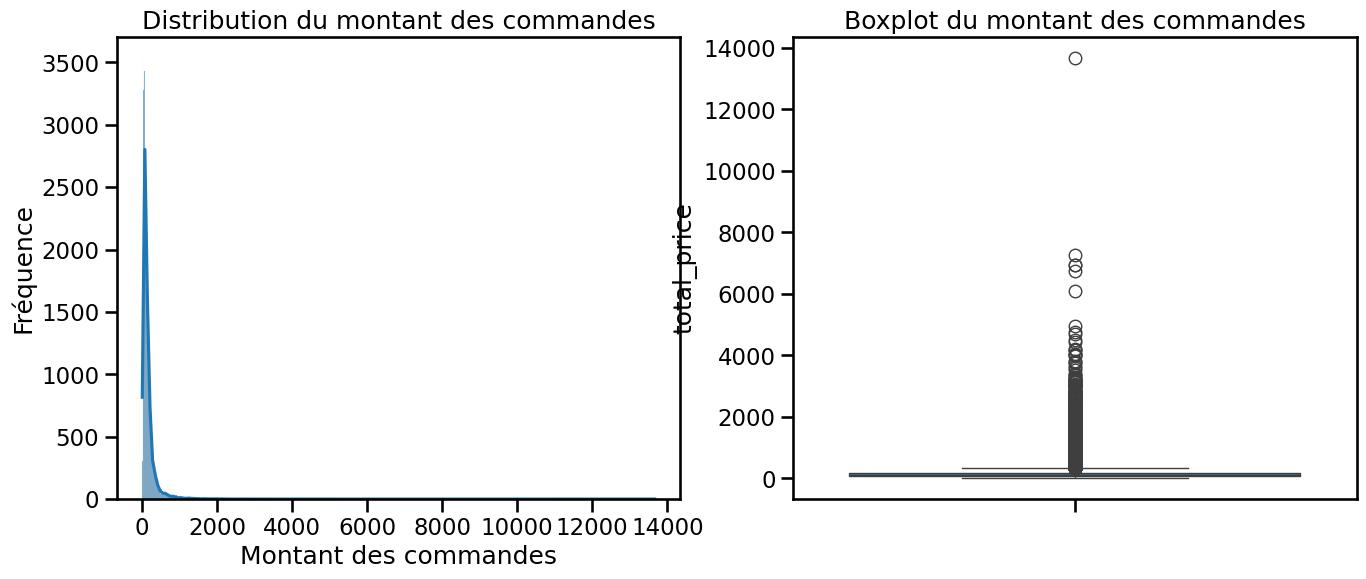

In [32]:
# Distribution du montant des commandes
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data['total_price'], kde=True, ax=ax0)
ax0.set_title('Distribution du montant des commandes')
ax0.set_xlabel('Montant des commandes')
ax0.set_ylabel('Fréquence')


sns.boxplot(data['total_price'], ax=ax1)
ax1.set_title('Boxplot du montant des commandes')

plt.show()

## | Nombre d'articles par commande

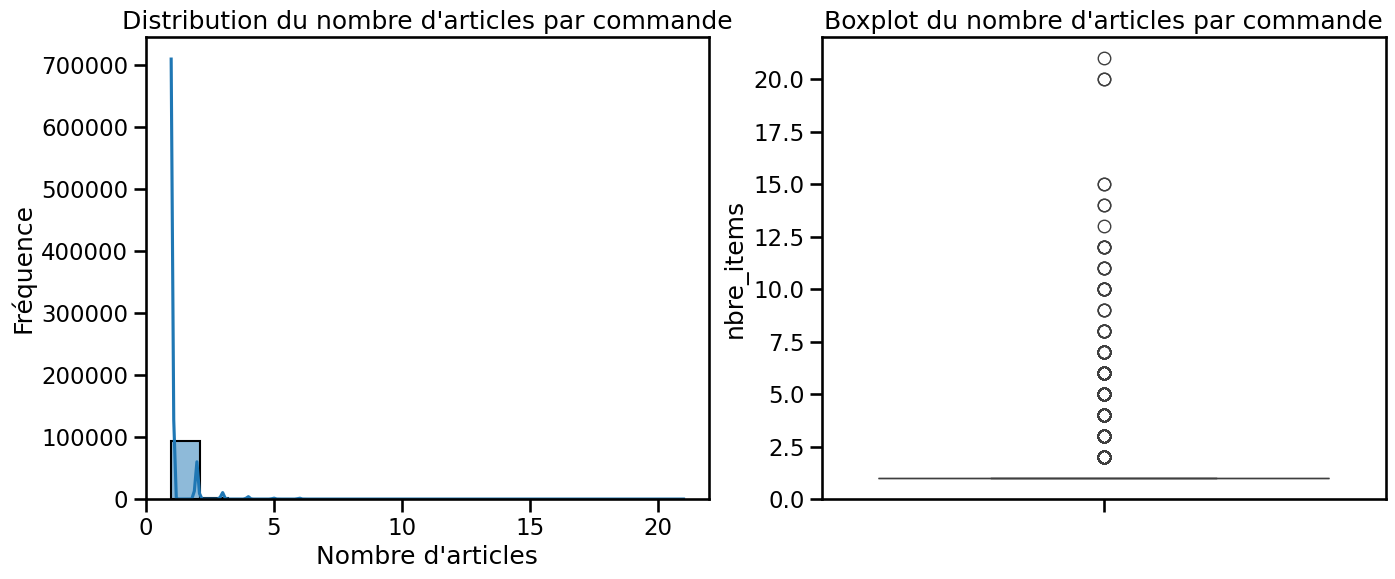

In [33]:
# Distribution du nombre d'articles par commande
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data['nbre_items'], kde=True, ax=ax0)
ax0.set_title('Distribution du nombre d\'articles par commande')
ax0.set_xlabel('Nombre d\'articles')
ax0.set_ylabel('Fréquence')

sns.boxplot(data['nbre_items'], ax=ax1)
ax1.set_title('Boxplot du nombre d\'articles par commande')

plt.show()

## | RFM Feature engineering

In [34]:
%%time
rfm_df = data.copy()

# Recency
last_date = rfm_df['order_purchase_timestamp'].max()
rfm_df['Recency'] = (last_date - rfm_df['order_purchase_timestamp']).dt.days

# Frequency
frequency = rfm_df.groupby('customer_unique_id')['order_id'].count().reset_index()
frequency.columns = ['customer_unique_id', 'Frequency']
rfm_df = rfm_df.merge(frequency, on='customer_unique_id')


# Monetary Value
monetary_value = rfm_df.groupby('customer_unique_id')['total_price'].sum().reset_index()
monetary_value.columns = ['customer_unique_id', 'MonetaryValue']
rfm_df = rfm_df.merge(monetary_value, on='customer_unique_id')

def rfm_score(x, p, d, invert=False):
    """
      Attribue un score de 1 à 4 selon les quartiles.
      - Si `invert=True`, l'échelle est inversée (utile pour Recency où un plus petit x est meilleur).
    """
    if invert:
        if x <= d[p][0.25]:
            return 4  # Meilleur score
        elif x <= d[p][0.50]:
            return 3
        elif x <= d[p][0.75]:
            return 2
        else:
            return 1  # Moins bon score
    else:
        if x <= d[p][0.25]:
            return 1
        elif x <= d[p][0.50]:
            return 2
        elif x <= d[p][0.75]:
            return 3
        else:
            return 4

def last_purch_day_of_week(data):
  return data.max().dayofweek

quantiles = rfm_df[['Recency', 'Frequency', 'MonetaryValue']].quantile(q=[0.25, 0.5, 0.75])
rfm_df['R'] = rfm_df['Recency'].apply(rfm_score, args=('Recency', quantiles, True))
rfm_df['F'] = rfm_df['Frequency'].apply(rfm_score, args=('Frequency', quantiles))
rfm_df['M'] = rfm_df['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles))

rfm_df['RFM_Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)
rfm_df['RFM_Score'] = rfm_df[['R', 'F', 'M']].sum(axis=1)

rfm_df = rfm_df.groupby('customer_unique_id').agg(
    recency=('Recency', 'min'),
    frequency=('Frequency', 'max'),
    monetary=('MonetaryValue', 'sum'),
    rfm_score=('RFM_Score', 'max'),
    rfm_segment=('RFM_Segment', 'max'),
    satisfaction=('mean_score_review', 'mean'),
    nbre_items=('nbre_items', 'mean'),
    distinct_products=('distinct_products', 'mean'),
    first_purch_at=('order_purchase_timestamp', 'min'),
    last_purch_at=('order_purchase_timestamp', 'max'),
    last_purch_day_of_week=('order_purchase_timestamp', last_purch_day_of_week),
    customer_zip_code_prefix=('customer_zip_code_prefix', 'first')
).reset_index()

geoloc_data = orders = pd.read_sql(
    """
    SELECT
      geolocation_zip_code_prefix as customer_zip_code_prefix,
      AVG(geolocation_lat) as lat,
      AVG(geolocation_lng) as lng,
      geolocation_city as customer_city,
      geolocation_state as customer_state
    FROM geoloc
    GROUP BY geolocation_zip_code_prefix
    """,
    conn
)
#print("difference")
#print(set(rfm_df.customer_zip_code_prefix.to_list()).difference(set(geoloc_data.customer_zip_code_prefix)))
rfm_df_ = rfm_df.merge(geoloc_data, on="customer_zip_code_prefix")


display(rfm_df)

,customer_unique_id,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,first_purch_at,last_purch_at,last_purch_day_of_week,customer_zip_code_prefix
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,8,413,5.0,1.0,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,3,7787
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,6,411,4.0,1.0,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,6053
2,0000f46a3911fa3c0805444483337064,536,1,86.22,4,112,3.0,1.0,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,4,88115
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4,211,4.0,1.0,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,3,66812
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,7,214,5.0,1.0,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,1,18040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,446,1,2067.42,6,114,5.0,2.0,2.0,2017-06-08 21:00:36,2017-06-08 21:00:36,3,55250
93353,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,5,212,4.0,1.0,1.0,2017-12-10 20:07:56,2017-12-10 20:07:56,6,44054
93354,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5,113,5.0,1.0,1.0,2017-02-07 15:49:16,2017-02-07 15:49:16,1,78552
93355,ffff5962728ec6157033ef9805bacc48,118,1,133.69,7,313,5.0,1.0,1.0,2018-05-02 15:17:41,2018-05-02 15:17:41,2,29460


CPU times: user 18.4 s, sys: 237 ms, total: 18.6 s
Wall time: 18.7 s


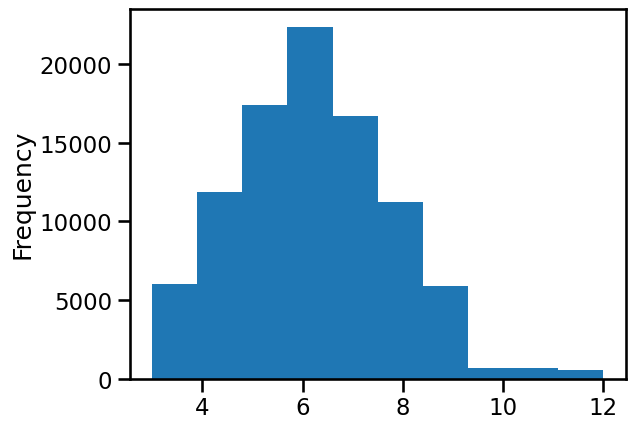

In [35]:
rfm_df.rfm_score.plot.hist()
plt.show()

In [36]:
rfm_df['rfm_segment_loyalty'] = pd.qcut(rfm_df.rfm_score, duplicates='drop', q=4, labels=['inactive', 'risk (bronze)', 'good (silver)', 'top (Gold)'])
display(rfm_df[['rfm_score','rfm_segment_loyalty']].sort_values(by='rfm_segment_loyalty', ascending=False))

,rfm_score,rfm_segment_loyalty
0,8,top (Gold)
68670,9,top (Gold)
24914,9,top (Gold)
68598,9,top (Gold)
68600,9,top (Gold)
...,...,...
29058,5,inactive
29057,5,inactive
29054,5,inactive
29053,5,inactive


In [37]:
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,first_purch_at,last_purch_at,last_purch_day_of_week,customer_zip_code_prefix,rfm_segment_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,8,413,5.0,1.0,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,3,7787,top (Gold)
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,6,411,4.0,1.0,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,6053,risk (bronze)
2,0000f46a3911fa3c0805444483337064,536,1,86.22,4,112,3.0,1.0,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,4,88115,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4,211,4.0,1.0,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,3,66812,inactive
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,7,214,5.0,1.0,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,1,18040,good (silver)


### | Analayse des variables rfm

In [38]:
rfm_df.describe()

,recency,frequency,monetary,rfm_score,satisfaction,nbre_items,distinct_products,first_purch_at,last_purch_at,last_purch_day_of_week,customer_zip_code_prefix
count,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357,93357,93357.000000,93357.000000
mean,236.936673,1.033420,176.460376,6.074306,4.126214,1.139511,1.037352,2018-01-01 12:25:50.133583872,2018-01-04 03:54:56.246505472,2.756033,35241.436111
min,0.000000,1.000000,9.590000,3.000000,0.000000,1.000000,1.000000,2016-10-03 09:44:50,2016-10-03 16:56:50,0.000000,1003.000000
25%,113.000000,1.000000,63.100000,5.000000,4.000000,1.000000,1.000000,2017-09-13 16:03:18,2017-09-17 18:27:12,1.000000,11410.000000
50%,218.000000,1.000000,108.410000,6.000000,5.000000,1.000000,1.000000,2018-01-20 07:46:14,2018-01-23 00:18:46,3.000000,24452.000000
75%,345.000000,1.000000,186.950000,7.000000,5.000000,1.000000,1.000000,2018-05-05 14:16:29,2018-05-07 17:23:11,4.000000,59075.000000
max,694.000000,15.000000,18623.520000,12.000000,5.000000,21.000000,8.000000,2018-08-29 15:00:37,2018-08-29 15:00:37,6.000000,99980.000000
std,152.584315,0.209099,281.875843,1.729592,1.319043,0.527042,0.220850,NaN,NaN,1.967601,29842.837938


In [39]:
def plot_distribution(df, features=None):
  if not features:
    features = ['recency', 'monetary', 'frequency']
  plt.figure(figsize=(15, 5))

  fig  = plt.figure(figsize=(16, 8))
  n_cols = len(features)
  n_rows = 2

  colors = mpl.colormaps.get_cmap('viridis').colors
  for i,feat in enumerate(features):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    sns.boxplot(data=df[feat], color=colors[i])
    ax.set_title(f"{feat} Value Boxplot")
    ax.set_xlabel(feat)
    ax.set_ylabel("Count")
    ax = fig.add_subplot(n_rows, n_cols, i+1+n_cols)
    sns.histplot(df[feat], kde=True, ax=ax, color=colors[i])
    ax.set_title(f"{feat} Distribution")
    ax.set_xlabel(feat)
    ax.set_ylabel("Count")

  plt.tight_layout()
  plt.show()

<Figure size 1500x500 with 0 Axes>

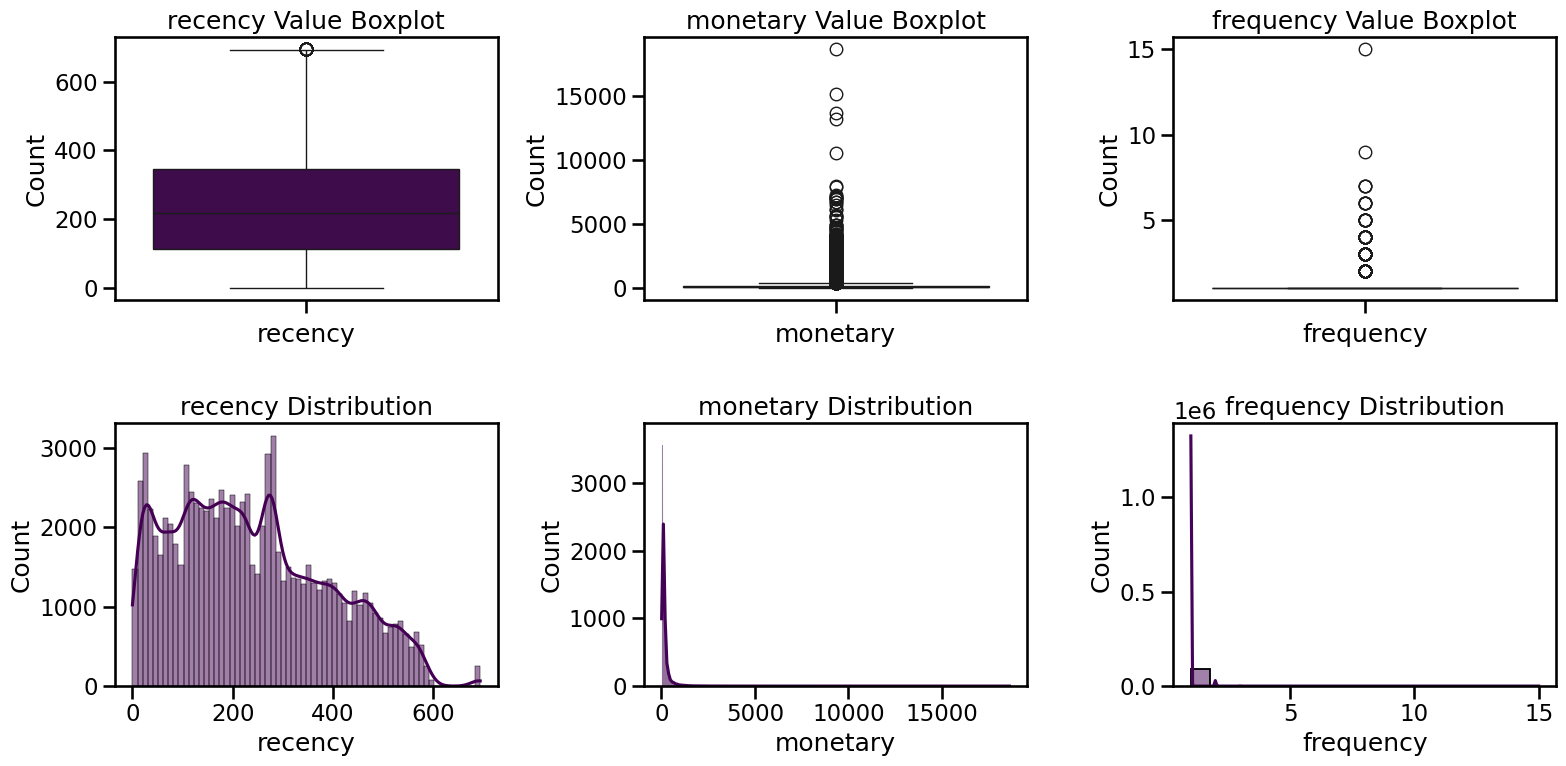

In [40]:
plot_distribution(rfm_df)

In [41]:
rfm_df[['recency', 'monetary', 'frequency']].skew()

,0
recency,0.447277
monetary,13.875540
frequency,11.095096


### | Transformation des variables asymetriques

On remarque une forte asymetrie dans la distribution des valeurs pour les caractéristiques **monetary** et **frequency**.

Les algorithmes de clustering (K-means, HAC, DBSCAN, etc.) se basent souvent sur des mesures de distance (euclidienne, Manhattan, etc.). Si une variable est très étalée, elle peut dominer les distances et « écraser » l’information apportée par d’autres variables. La log-transformation peut aider à mieux équilibrer l’impact de chaque variable.

In [42]:
rfm_df['monetary'] = np.log(rfm_df['monetary'])

<Figure size 1500x500 with 0 Axes>

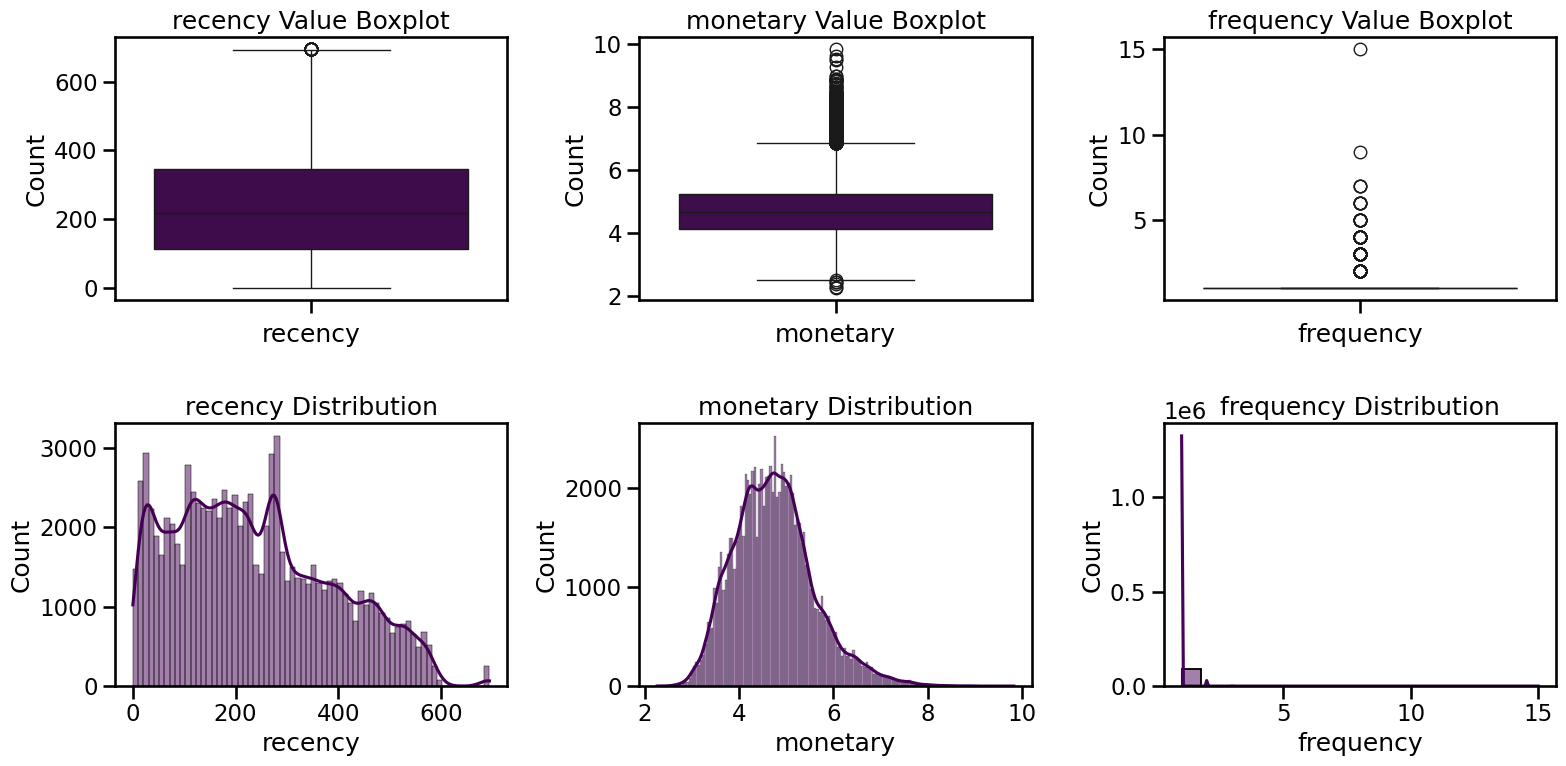

In [43]:
plot_distribution(rfm_df)

### | Gestion des outliers avec la methode statistique IQR

In [44]:
M_Q1 = rfm_df["monetary"].quantile(0.25)
M_Q3 = rfm_df["monetary"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = rfm_df[(rfm_df["monetary"] > (M_Q3 + 1.5 * M_IQR)) | (rfm_df["monetary"] < (M_Q1 - 1.5 * M_IQR))].copy()

print(f"Nombre d'outliers: {len(monetary_outliers_df)}")
monetary_outliers_df.describe()

Nombre d'outliers: 1623


,recency,frequency,monetary,rfm_score,satisfaction,nbre_items,distinct_products,first_purch_at,last_purch_at,last_purch_day_of_week,customer_zip_code_prefix
count,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1623,1623,1623.000000,1623.000000
mean,231.569932,1.423290,7.288159,8.405422,3.943096,1.521539,1.090198,2017-12-10 03:05:59.094885888,2018-01-09 12:45:24.348736768,2.710413,39705.930376
min,3.000000,1.000000,2.260721,3.000000,0.000000,1.000000,1.000000,2016-10-04 14:49:13,2016-10-04 19:25:29,0.000000,1009.000000
25%,107.000000,1.000000,7.006132,7.000000,3.000000,1.000000,1.000000,2017-08-18 15:32:30,2017-09-14 22:10:25,1.000000,13540.000000
50%,208.000000,1.000000,7.199238,8.000000,5.000000,1.000000,1.000000,2017-12-12 18:19:22,2018-02-01 17:05:51,3.000000,30620.000000
75%,348.000000,2.000000,7.508770,9.000000,5.000000,1.333333,1.000000,2018-04-20 18:17:58,2018-05-14 10:35:20.500000,4.000000,66352.500000
max,693.000000,15.000000,9.832181,12.000000,5.000000,20.000000,8.000000,2018-08-26 07:38:38,2018-08-26 12:38:57,6.000000,99670.000000
std,153.941335,0.879342,0.497834,1.883348,1.451667,1.475208,0.412250,NaN,NaN,1.964213,29638.806538


In [45]:
M_Q1 = rfm_df["frequency"].quantile(0.25)
M_Q3 = rfm_df["frequency"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

frequency_outliers_df = rfm_df[(rfm_df["frequency"] > (M_Q3 + 1.5 * M_IQR)) | (rfm_df["frequency"] < (M_Q1 - 1.5 * M_IQR))].copy()

print(f"Nombre d'outliers: {len(frequency_outliers_df)}")
frequency_outliers_df.describe()

Nombre d'outliers: 2801


,recency,frequency,monetary,rfm_score,satisfaction,nbre_items,distinct_products,first_purch_at,last_purch_at,last_purch_day_of_week,customer_zip_code_prefix
count,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801,2801,2801.000000,2801.000000
mean,219.294538,2.113888,6.196920,10.108890,4.170993,1.213956,1.071424,2017-10-25 15:36:19.940378368,2018-01-21 19:33:14.957872384,2.791860,33777.118886
min,0.000000,2.000000,4.274998,6.000000,0.000000,1.000000,1.000000,2016-10-03 09:44:50,2016-10-07 08:28:29,0.000000,1005.000000
25%,104.000000,2.000000,5.690427,9.000000,3.500000,1.000000,1.000000,2017-07-02 13:09:40,2017-10-16 22:24:02,1.000000,9720.000000
50%,198.000000,2.000000,6.132052,10.000000,4.500000,1.000000,1.000000,2017-10-31 13:35:53,2018-02-11 20:24:37,3.000000,22773.000000
75%,316.000000,2.000000,6.619540,11.000000,5.000000,1.000000,1.000000,2018-02-18 09:36:01,2018-05-16 20:57:48,4.000000,51021.000000
max,691.000000,15.000000,9.832181,12.000000,5.000000,9.000000,3.500000,2018-08-22 20:43:48,2018-08-28 21:56:12,6.000000,99750.000000
std,143.650583,0.503796,0.742655,1.374226,1.110349,0.552147,0.228624,NaN,NaN,1.975353,29792.066363


In [46]:
intersection_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)
monetary_frequency_outliers_df = rfm_df[(rfm_df.index.isin(intersection_indices))]
frequency_outliers_df = frequency_outliers_df[~(frequency_outliers_df.index.isin(intersection_indices))]
monetary_outliers_df = monetary_outliers_df[~(monetary_outliers_df.index.isin(intersection_indices))]

In [47]:
display(monetary_frequency_outliers_df.loc[:,['frequency', 'monetary']].describe())

,frequency,monetary
count,464.000000,464.000000
mean,2.480603,7.399723
std,1.067713,0.501446
min,2.000000,6.861586
25%,2.000000,7.026107
50%,2.000000,7.260227
75%,3.000000,7.643315
max,15.000000,9.832181


In [48]:
display(frequency_outliers_df.loc[:,['frequency', 'monetary']].describe())

,frequency,monetary
count,2337.000000,2337.000000
mean,2.041078,5.958109
std,0.215075,0.516556
min,2.000000,4.274998
25%,2.000000,5.608446
50%,2.000000,5.993612
75%,2.000000,6.359954
max,6.000000,6.859132


In [49]:
display(monetary_outliers_df.loc[:,['frequency', 'monetary']].describe())

,frequency,monetary
count,1159.0,1159.000000
mean,1.0,7.243495
std,0.0,0.489515
min,1.0,2.260721
25%,1.0,6.999450
50%,1.0,7.187884
75%,1.0,7.456379
max,1.0,9.522526


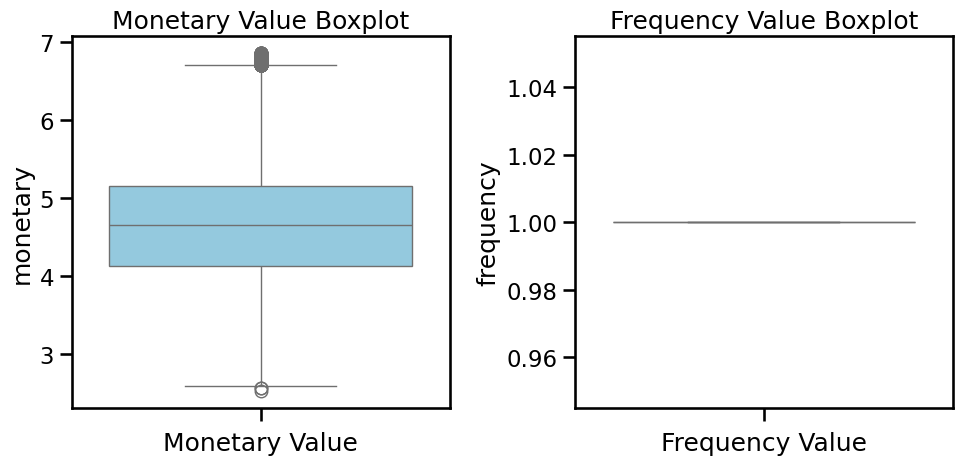

In [50]:
plt.figure(figsize=(15, 5))
df_ = rfm_df[
    (~rfm_df.index.isin(monetary_frequency_outliers_df.index)) &
    (~rfm_df.index.isin(monetary_outliers_df.index)) &
    (~rfm_df.index.isin(frequency_outliers_df.index))
]
plt.subplot(1, 3, 1)
sns.boxplot(data=df_['monetary'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=df_['frequency'], color='skyblue')
plt.title('Frequency Value Boxplot')
plt.xlabel('Frequency Value')

plt.tight_layout()
plt.show()

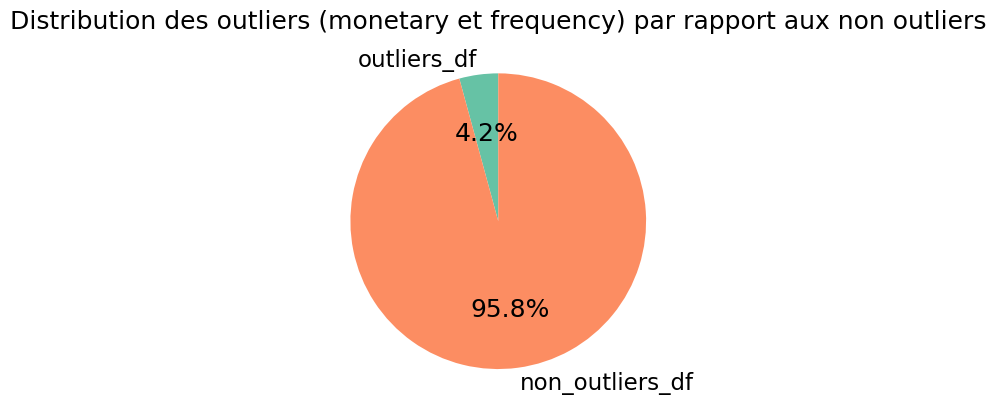

In [51]:
outliers_len = len(monetary_outliers_df) + len(frequency_outliers_df) + len(monetary_frequency_outliers_df)
non_outliers_len = len(rfm_df) - outliers_len
counts = [outliers_len, non_outliers_len]

plt.pie(counts, autopct="%1.1f%%", labels=["outliers_df", "non_outliers_df"],startangle=90, colors=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"])
plt.title("Distribution des outliers (monetary et frequency) par rapport aux non outliers")
plt.ylabel("")  # Remove default ylabel
plt.show()

## | Sauvegarde des données nettoyées

In [52]:
rfm_df = rfm_df[
    (~rfm_df.index.isin(monetary_frequency_outliers_df.index)) &
    (~rfm_df.index.isin(monetary_outliers_df.index)) &
    (~rfm_df.index.isin(frequency_outliers_df.index))
]

<Figure size 1500x500 with 0 Axes>

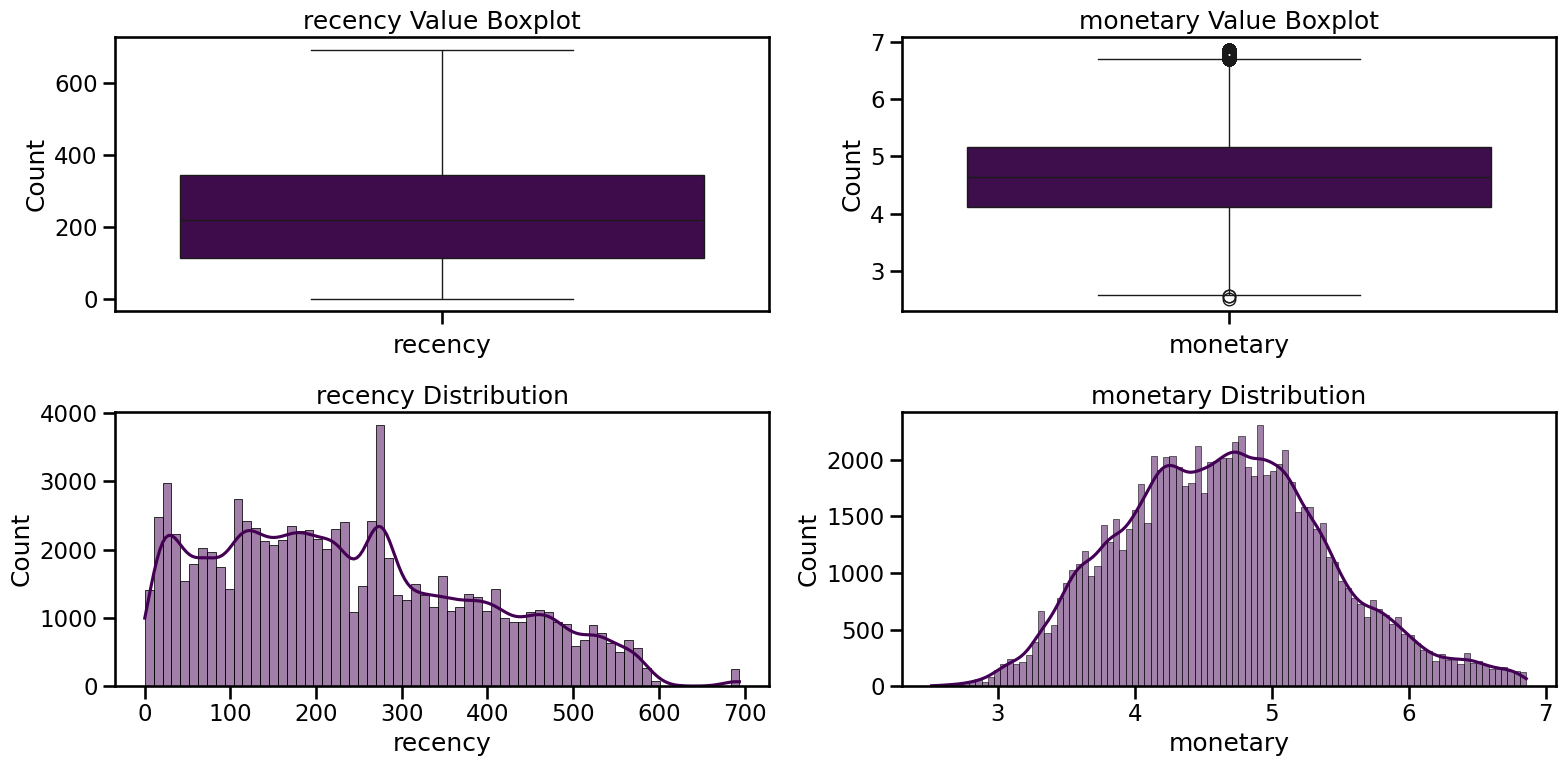

In [53]:
plot_distribution(rfm_df, features=['recency', 'monetary'])

In [54]:
rfm_df.to_csv(f"{folder_path}olist_customer_cleaned_data.csv", index=False)
monetary_frequency_outliers_df.to_csv(f"{folder_path}olist_customer_monetary_frequency_outliers.csv", index=False)
monetary_outliers_df.to_csv(f"{folder_path}olist_customer_monetary_outliers.csv", index=False)
frequency_outliers_df.to_csv(f"{folder_path}olist_customer_frequency_outliers.csv", index=False)

# données orders pour la simulation plus tard
data.to_csv(f"{folder_path}olist_orders_cleaned_data.csv", index=False)

In [55]:
elapsed_time = time.time() - init_time
print(f"Le duréee totale de l'execution du notebook est de {elapsed_time} secondes")

Le duréee totale de l'execution du notebook est de 56.69126033782959 secondes


# FIN